# Final competition of Deep Learning 2020 Spring
Traffic environment semi-supervised Learning Contest

## Goals
The objective is to train a model using images captured by six different cameras attached to the same car to generate a top down view of the surrounding area. The performance of the model will be evaluated by (1) the ability of detecting objects (like car, trucks, bicycles, etc.) and (2) the ability to draw the road map layout.

## Data
You will be given two sets of data:

 1. Unlabeled set: just images
 2. Labeled set: images and the labels(bounding box and road map layout)

This notebook will help you understand the dataset.

In [1]:
from google.colab import drive
drive.mount('/data/')
from pathlib import Path
base_dir = ('/data/My Drive')


Mounted at /data/


In [0]:
#!cp  /data/My\ Drive/DeepLearning/student_data.zip /content/
#!unzip student_data.zip

In [0]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
#import utils

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box


import torchvision.transforms as transforms


In [0]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [0]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# Dataset

You will get two different datasets:

 1. an unlabeled dataset for pre-training
 2. a labeled dataset for both training and validation
 
## The dataset is organized into three levels: scene, sample and image

 1. A scene is 25 seconds of a car's journey.
 2. A sample is a snapshot of a scene at a given timeframe. Each scene will be divided into 126 samples, so about 0.2 seconds between consecutive samples.
 3. Each sample contains 6 images captured by camera facing different orientation.
    Each camera will capture 70 degree view. To make it simple, you can safely assume that the angle between the cameras is 60 degrees 

106 scenes in the unlabeled dataset and 28 scenes in the labeled dataset

In [0]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 128)

## validation scene index.
validation_scene_index = np.arange(128, 134)

# Unlabeled dataset

You get two ways to access the dataset, by sample or by image

## Get Sample

In [0]:
'''transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    # Resize image to 224 x 224 as required by most vision models
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    # Convert PIL image to tensor with image values in [0, 1]
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])'''

from torch.autograd import Variable

transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

In [8]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([3, 6, 3, 256, 306])


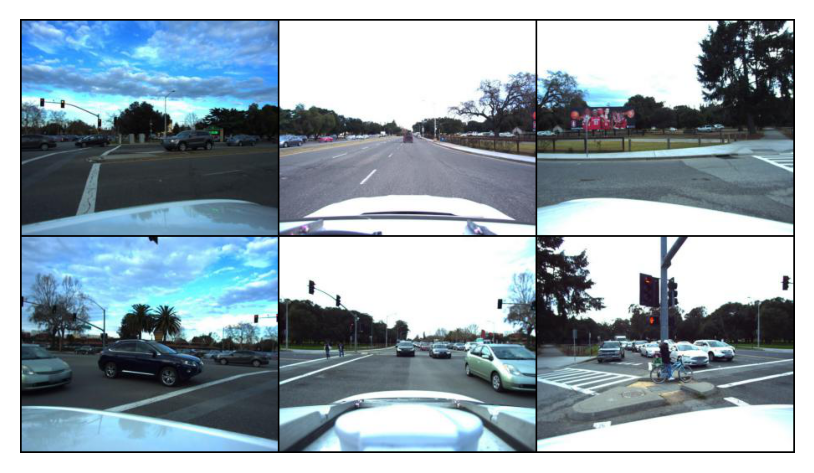

In [9]:
# The 6 images orgenized in the following order:
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

## Get individual image

In [0]:
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=2, shuffle=True, num_workers=2)

In [11]:
# [batch_size, 3, H, W]
image, camera_index = iter(trainloader).next()
print(image.shape)

torch.Size([2, 3, 256, 306])


In [12]:
# Camera_index is to tell you which camera is used. The order is
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
print(camera_index[0])

tensor(2)


In [13]:
print(camera_index)

tensor([2, 1])


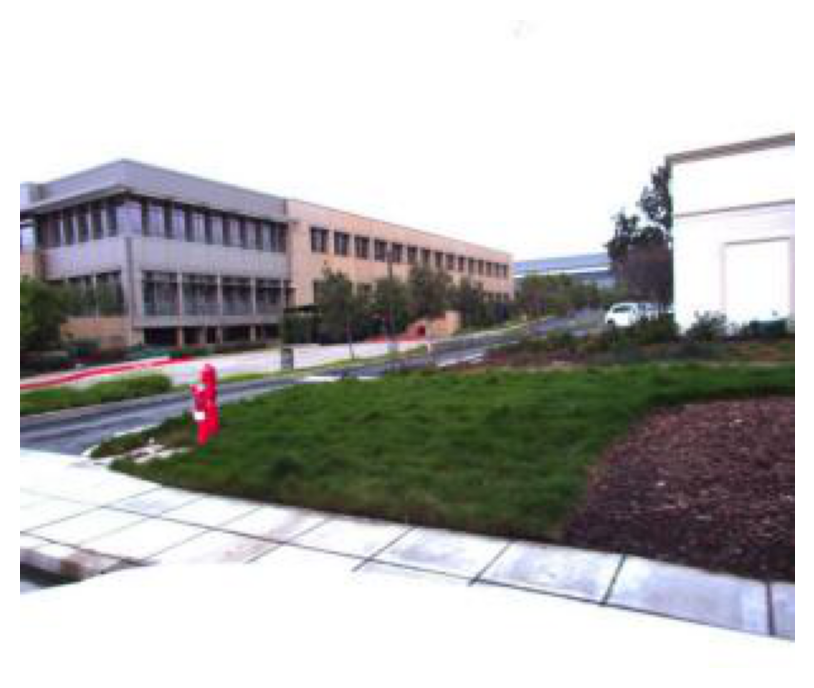

In [14]:
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.axis('off');

# Labeled dataset

In [0]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [0]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
validation_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=validation_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
valLoader = torch.utils.data.DataLoader(validation_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

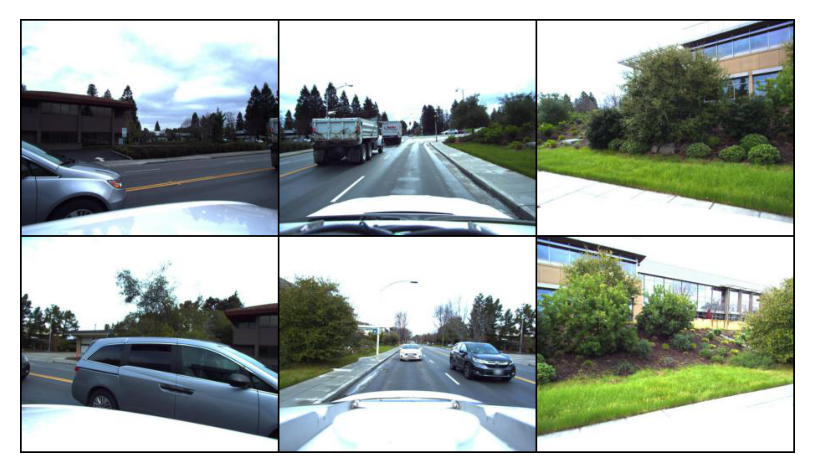

In [17]:
# The 6 images orgenized in the following order:
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [18]:
len(sample)

3

In [19]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)
print("########")
print(len(target))
print(target[0].keys())
print(target)
print("########")
print(len(road_image))
print(torch.stack(road_image).shape)
print(road_image)
print(road_image[0].size())
print("########")
print(len(extra))
print(extra)
print("########")

torch.Size([2, 6, 3, 256, 306])
########
2
dict_keys(['bounding_box', 'category'])
({'bounding_box': tensor([[[-32.0398, -31.9963, -24.4213, -24.3778],
         [ 20.8539,  23.1693,  20.7102,  23.0256]],

        [[ 18.8433,  18.8662,  19.7978,  19.8207],
         [ -7.6227,  -6.8701,  -7.6518,  -6.8992]],

        [[-18.1843, -18.2198, -20.1210, -20.1565],
         [ -6.8239,  -7.7972,  -6.7532,  -7.7264]],

        [[  7.7710,   5.8641,   7.7773,   5.8703],
         [ 10.0418,  10.0443,  14.9793,  14.9818]],

        [[ -3.7765,  -3.6891,  -8.6849,  -8.5975],
         [ -2.7996,  -4.8365,  -3.0098,  -5.0467]],

        [[ 21.2550,  21.2990,  16.4586,  16.5026],
         [ -2.7451,  -4.4754,  -2.8667,  -4.5970]],

        [[  9.1144,   9.1148,   5.1584,   5.1589],
         [ -2.7186,  -4.4015,  -2.7194,  -4.4023]]], dtype=torch.float64), 'category': tensor([2, 3, 1, 2, 2, 2, 2])}, {'bounding_box': tensor([[[  4.1652,   4.1487,  -0.3996,  -0.4160],
         [  4.3936,   2.6337,   4.436

In [20]:
sample, target, road_image, extra = iter(valLoader).next()
print(torch.stack(sample).shape)
print("########")
print(target)
print(target[0].keys())
print(target)
print("########")
#print(torch.stack(target).shape)
print(len(road_image))
print(torch.stack(road_image).shape)
print(road_image)
print(road_image[0].size())
print("########")
print(len(extra))
print(extra)
print("########")
print(target[0]['bounding_box'].shape)
print(target[0]['category'].shape)

torch.Size([2, 6, 3, 256, 306])
########
({'bounding_box': tensor([[[ 10.0939,  10.0597,   5.7578,   5.7236],
         [  7.8814,   6.2043,   7.9695,   6.2925]],

        [[ 29.8932,  31.6843,  27.9769,  29.7680],
         [-12.4105, -13.2036, -16.7346, -17.5277]],

        [[ 37.7997,  36.0237,  38.8790,  37.1031],
         [ 28.9728,  29.4421,  33.0531,  33.5225]],

        [[ 33.3400,  35.0488,  31.6266,  33.3354],
         [-11.3108, -12.0674, -15.1770, -15.9337]],

        [[-29.9652, -30.0370, -34.2161, -34.2879],
         [  0.9009,  -0.9941,   1.0615,  -0.8335]],

        [[ 21.4906,  21.4220,  16.7560,  16.6874],
         [ 11.4466,   9.6355,  11.6255,   9.8144]],

        [[ 14.1124,  14.0380,   9.3928,   9.3184],
         [  4.0155,   2.0496,   4.1938,   2.2279]],

        [[-32.9129, -32.8733, -22.8140, -22.7743],
         [ 25.2315,  28.0212,  25.0887,  27.8785]],

        [[ -4.5073,  -4.5444,  -8.9904,  -9.0274],
         [  0.9866,  -0.8284,   1.0777,  -0.7373]],

     

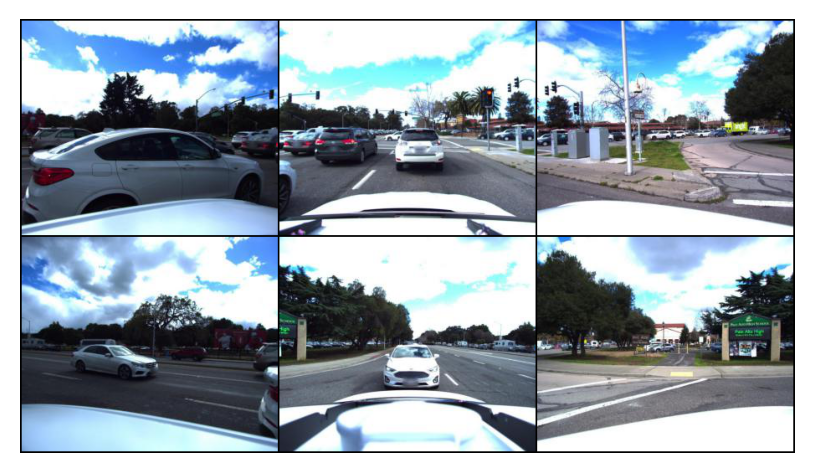

In [21]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [22]:
'''tp = np.zeros((2,3,3,512,306))
for i in range(0,2):
    for j in range(0,3):
        for k in range(0,3):
            tp[i][j][k] = np.vstack([t[i][j][k][0], t[i][j][k][1]])
#print(th.shape)
print(tp.shape)'''

'tp = np.zeros((2,3,3,512,306))\nfor i in range(0,2):\n    for j in range(0,3):\n        for k in range(0,3):\n            tp[i][j][k] = np.vstack([t[i][j][k][0], t[i][j][k][1]])\n#print(th.shape)\nprint(tp.shape)'

In [23]:
'''tr = np.zeros((2,3,512,918))
for i in range(0,2):
    for j in range(0,3):
        tr[i][j] = np.hstack([tp[i][j][0], tp[i][j][1], tp[i][j][2]])
#print(th.shape)
print(tr.shape)'''

'tr = np.zeros((2,3,512,918))\nfor i in range(0,2):\n    for j in range(0,3):\n        tr[i][j] = np.hstack([tp[i][j][0], tp[i][j][1], tp[i][j][2]])\n#print(th.shape)\nprint(tr.shape)'

In [24]:
'''fig, ax = plt.subplots()

ax.imshow(tr[0].transpose(1, 2, 0));


#plt.imshow(tr[0]);'''

'fig, ax = plt.subplots()\n\nax.imshow(tr[0].transpose(1, 2, 0));\n\n\n#plt.imshow(tr[0]);'

In [0]:
stacked_road_image = torch.stack(road_image)
roadImageNew = stacked_road_image.reshape(2, 800*800)

In [26]:
roadImageNew.shape

torch.Size([2, 640000])

In [27]:
roadImageNew.size()

torch.Size([2, 640000])

In [28]:
roadImageNew.dtype

torch.bool

In [29]:
print(roadImageNew)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [0]:
#roadImageNewf = roadImageNew.type(torch.float)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#from resnet14 import BasicBlock, Bottleneck, ResNet, ResNet18

#model = ResNet18()
#model.to(device)
#print(model)

In [0]:
def modify_output_for_loss_fn(loss_fn, output, dim):
    if loss_fn == "ce":
        return output
    if loss_fn == "mse":
        return F.softmax(output, dim=dim)
    if loss_fn == "nll":
        return F.log_softmax(output, dim=dim)
    if loss_fn in ["bce", "wbce", "wbce1"]:
        return torch.sigmoid(output)

In [0]:
model1 = torchvision.models.resnet34(pretrained=False)

In [35]:
print(model1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
model1.conv1 = nn.Conv2d(18, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [0]:
model1.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=512,
        out_features=640000
    ),
    torch.nn.Sigmoid()
)

In [38]:
print(model1)

ResNet(
  (conv1): Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
import torch.optim as optim
#optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [40]:
from torch.autograd import Variable
'''
def train(epoch):
    total_loss = 0
    model.train()
    model.to(device)
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        #print(batch_idx)
        #print(len(sample))
        #print(len(road_image))
        stacked_sample = torch.stack(sample)
        sampleNew = stacked_sample.reshape(2,18,256,306)
        stacked_roadImage = torch.stack(road_image)
        roadImageNew = stacked_roadImage.reshape(2, 800*800)
        roadImageNewf = roadImageNew.type(torch.float)
        sample, road_image = Variable(sampleNew).to(device), Variable(roadImageNewf).to(device)
        optimizer.zero_grad()
        output = model(sample)
        
        #print(output.shape)
        #output = torch.sigmoid(output)
        #print(output)
        ##############
        # CHANGE LOSS FUNCTION 
        ##############
        #loss = F.nll_loss(output, road_image)
        #output = F.log_softmax(output)
        loss_func = nn.BCELoss()
    

        loss = loss_func(output,road_image)
        #print(loss)
        loss.backward()
        optimizer.step()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))
           total_loss += loss.item()
    total_loss_div = total_loss/ len(trainloader)
    print("@@@@@@@@@@@@@")
    print(total_loss_div)
    print("@@@@@@@@@@@@@")
    return total_loss'''

'\ndef train(epoch):\n    total_loss = 0\n    model.train()\n    model.to(device)\n    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):\n        #print(batch_idx)\n        #print(len(sample))\n        #print(len(road_image))\n        stacked_sample = torch.stack(sample)\n        sampleNew = stacked_sample.reshape(2,18,256,306)\n        stacked_roadImage = torch.stack(road_image)\n        roadImageNew = stacked_roadImage.reshape(2, 800*800)\n        roadImageNewf = roadImageNew.type(torch.float)\n        sample, road_image = Variable(sampleNew).to(device), Variable(roadImageNewf).to(device)\n        optimizer.zero_grad()\n        output = model(sample)\n        \n        #print(output.shape)\n        #output = torch.sigmoid(output)\n        #print(output)\n        ##############\n        # CHANGE LOSS FUNCTION \n        ##############\n        #loss = F.nll_loss(output, road_image)\n        #output = F.log_softmax(output)\n        loss_func = nn.BCELoss()\n 

In [0]:
#print(type(sample))
#print(type(road_image))

In [42]:
'''i=1
for epoch in range(1, 2):
    print("Epoch:")
    print(i)
    epoch_loss = train(epoch)
    #print(epoch_loss)
    i += 1'''

'i=1\nfor epoch in range(1, 2):\n    print("Epoch:")\n    print(i)\n    epoch_loss = train(epoch)\n    #print(epoch_loss)\n    i += 1'

In [0]:
def compute_iou(pred, target):
    p = pred.cpu().numpy()
    t = target.cpu().numpy()
    I =   len(np.argwhere(np.logical_and(p==1,t==1)))/len(np.argwhere(np.logical_or(p==1,t==1)))
    #print(I)
    U =   len(np.argwhere(np.logical_and(p==0,t==0)))/len(np.argwhere(np.logical_or(p==0,t==0)))
    #print(U)
    mean_iou = (I+U)/2
    return mean_iou

In [44]:
# build a classifier to predict road image
'''
def validation():
    print("validation: \n")
    model.eval()
    model.to(device)
    validation_loss = 0
    total_iou = 0
    correct = 0
    #print("*******************")
    for batch_idx1, (sample1, target1, road_image1, extra1) in enumerate(valLoader):
        #print(sample1.shape)
        #print(road_image1.shape)
        stacked_sample1 = torch.stack(sample1)
        sampleNew1 = stacked_sample1.reshape(2,18,256,306)
        stacked_roadImage1 = torch.stack(road_image1)
        roadImageNew1 = stacked_roadImage1.reshape(2, 800*800)
        roadImageNewf1 = roadImageNew1.type(torch.float)
        sample1, road_image1 = Variable(sampleNew1).to(device), Variable(roadImageNewf1).to(device)
        output1 = model(sample1)
        #print(torch.unique(outputNew))
        #print(torch.unique(road_image1))
        #output1 = F.log_softmax(output1)
        # validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
        # loss_func = nn.CrossEntropyLoss()
        loss_func = nn.BCELoss()
        #vloss = loss_func(output1, road_image1)
        #print(vloss)
        validation_loss += loss_func(output1, road_image1).data.item() # sum up batch loss
        #print(outputNew.shape)
        #print(road_image1.shape)
        #p = ((outputNew1 == road_image1).sum().item())
        #print(p)
        #accuracy = p/(outputNew.size()[1]*2)
        #This conversion is only needed  to calculate accuracy.
        outputNew = output1 > 0.5 #what does this mean
        outputNew1 = outputNew.type(torch.float)
        iou = compute_iou(outputNew1,road_image1)
        #print(accuracy)
        total_iou += iou
        #pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        #correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    #print(len(valLoader))
    validation_loss /= len(valLoader)
    #total_acc /= len(valLoader)
    total_iou /= len(valLoader)
    print("!!!!")
    print('\n IOUy:')
    print(total_iou)
    print("!!!!")
    #print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    validation_loss, correct, len(validation_loss.dataset),
     #   100. * correct / len(validation_loss.dataset)))
    #print("*******************")
    print("@@@@@@@@@@@@@@@@@@@@")
    print('\nValidation loss: ')
    print(validation_loss)
    print("@@@@@@@@@@@@@@@@@@@@")
    #accuracy = correct / len(validation_loss.dataset) *100
    #return correct, accuracy
    return validation_loss'''

'\ndef validation():\n    print("validation: \n")\n    model.eval()\n    model.to(device)\n    validation_loss = 0\n    total_iou = 0\n    correct = 0\n    #print("*******************")\n    for batch_idx1, (sample1, target1, road_image1, extra1) in enumerate(valLoader):\n        #print(sample1.shape)\n        #print(road_image1.shape)\n        stacked_sample1 = torch.stack(sample1)\n        sampleNew1 = stacked_sample1.reshape(2,18,256,306)\n        stacked_roadImage1 = torch.stack(road_image1)\n        roadImageNew1 = stacked_roadImage1.reshape(2, 800*800)\n        roadImageNewf1 = roadImageNew1.type(torch.float)\n        sample1, road_image1 = Variable(sampleNew1).to(device), Variable(roadImageNewf1).to(device)\n        output1 = model(sample1)\n        #print(torch.unique(outputNew))\n        #print(torch.unique(road_image1))\n        #output1 = F.log_softmax(output1)\n        # validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss\n     

In [45]:
'''for epoch in range(0, 2):
    epoch_loss = train(epoch)
    epoch_loss = validation()'''

'for epoch in range(0, 2):\n    epoch_loss = train(epoch)\n    epoch_loss = validation()'

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# build a classifer for object detection

In [0]:
# build an end to end classifier for both lane image prediction with bounding boxes.

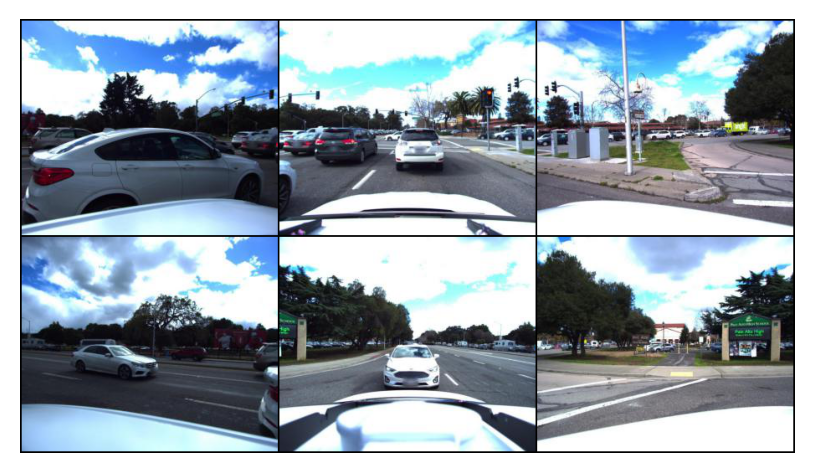

In [49]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [50]:
print(type(target[0]))

<class 'dict'>


There are two kind of labels

 1. The bounding box of surrounding objects
 2. The binary road_image

## Bounding box

In [51]:
print(target)

({'bounding_box': tensor([[[ 10.0939,  10.0597,   5.7578,   5.7236],
         [  7.8814,   6.2043,   7.9695,   6.2925]],

        [[ 29.8932,  31.6843,  27.9769,  29.7680],
         [-12.4105, -13.2036, -16.7346, -17.5277]],

        [[ 37.7997,  36.0237,  38.8790,  37.1031],
         [ 28.9728,  29.4421,  33.0531,  33.5225]],

        [[ 33.3400,  35.0488,  31.6266,  33.3354],
         [-11.3108, -12.0674, -15.1770, -15.9337]],

        [[-29.9652, -30.0370, -34.2161, -34.2879],
         [  0.9009,  -0.9941,   1.0615,  -0.8335]],

        [[ 21.4906,  21.4220,  16.7560,  16.6874],
         [ 11.4466,   9.6355,  11.6255,   9.8144]],

        [[ 14.1124,  14.0380,   9.3928,   9.3184],
         [  4.0155,   2.0496,   4.1938,   2.2279]],

        [[-32.9129, -32.8733, -22.8140, -22.7743],
         [ 25.2315,  28.0212,  25.0887,  27.8785]],

        [[ -4.5073,  -4.5444,  -8.9904,  -9.0274],
         [  0.9866,  -0.8284,   1.0777,  -0.7373]],

        [[  5.3289,   5.2621,   0.7902,   0.72

In [52]:
# The shape of bounding box is [batch_size, N (the number of object), 2, 4]
print(target[0]['bounding_box'].shape)

torch.Size([27, 2, 4])


In [0]:
#print(dtype(target[0]['bounding_box']))

In [54]:
# All bounding box are retangles
# Each bounding box is organized with four corners of the box
# All the values are in meter and bounded by 40 meters, and the origin is the center of ego car
# the order of the four courners are front left, front right, back left and back right
print(target[0]['bounding_box'][0])

tensor([[10.0939, 10.0597,  5.7578,  5.7236],
        [ 7.8814,  6.2043,  7.9695,  6.2925]], dtype=torch.float64)


In [55]:
# Each bounding box has a category
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8
print(target[0]['category'])

tensor([2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])


In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [0]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

In [0]:
num_classes = 9 
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

In [0]:
params = [p for p in model.parameters() if p.requires_grad]
optimizerNew = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizerNew,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
#model.backbone.body.conv1 = nn.Conv2d(18, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [61]:
print(model.roi_heads.mask_predictor)

None


In [62]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [0]:
#from torchsummary import summary
#summary(model, (18, 256, 306))
import cv2

In [0]:
def reshapeTarget(target):
    #print("!!!!")
    #print(type(target))
    targetNew = []
    
    for i in target:
        #print(type(i))
        #p=0
        kl = {}
        kl['boxes'] = []
        #kl['labels'] = []
        for j in i['bounding_box']:
            #print(type(j))
            #print("old")
            #print(j)
            #bbd = torch.zeros(1,4)
            ymin = torch.min(j[0])
            #bbd[0][1] = ymin
            #bbd[1] = ymin
            ymax = torch.max(j[0])
            #bbd[0][3] = ymax
            #bbd[3] = ymax
            xmin = torch.min(j[1])
            #bbd[0][0] = xmin
            #bbd[0] = xmin
            xmax = torch.max(j[1])
            #bbd[0][2] = xmax
            #bbd[2] = xmax
            bbd = torch.as_tensor([xmin, ymin, xmax, ymax], dtype=torch.float32)
            #print(bbd)
            torch.set_printoptions(precision=10)

            if bbd[0] > 0:
                bbd[0] = 400 + ((bbd[0])/40)*400
            elif bbd[0] < 0:
                bbd[0] = 400 - (((abs(bbd[0]))/40)*400)
            else:
                bbd[0] = 400
            if bbd[2] > 0:
                bbd[2] = 400 + ((bbd[2])/40)*400
            elif bbd[2] < 0:
                bbd[2] = 400 - ((abs(bbd[2])/40)*400)
            else:
                bbd[2] = 400 

            if bbd[1] > 0:
                bbd[1] = 400 + (bbd[1]/40)*400
            elif bbd[1] < 0:
                bbd[1] = 400 - ((abs(bbd[1]))/40)*400
            else:
                bbd[1] = 400
            if bbd[3] > 0:
                bbd[3] = 400 + (bbd[3]/40)*400
            elif bbd[3] < 0:
                bbd[3] = 400 - ((abs(bbd[3]))/40)*400
            else:
                bbd[3] = 400
            #print("new")
            #j = bbd
            #print(bbd)
            #print(type(j))
            kl['boxes'].append(bbd)
        kl['boxes'] = torch.stack(kl['boxes'])
        kl['labels'] = i['category']
        targetNew.append(kl)
    #print(">>>")
    #print(targetNew[0]['boxes'].shape)
    targetNew = tuple(targetNew)
    #print(targetNew[0])
    #print(len(targetNew))
    return targetNew
      

In [0]:
def trainNew(epoch):
    total_loss = 0
    model.train()
    #model.to(device)
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        stacked_sample = torch.stack(sample)
        ss = stacked_sample.reshape(2, 2, 3, 3,256,306)
        t = ss.numpy().transpose(0,3,2,1,4,5)
        #MergingImage
        tp = np.zeros((2,3,3,512,306))
        for i in range(0,2):
            for j in range(0,3):
                for k in range(0,3):
                    tp[i][j][k] = np.vstack([t[i][j][k][0], t[i][j][k][1]])
        #print("****")
        #print(tp.shape)
        tr = np.zeros((2,3,512,918))
        for i in range(0,2):
            for j in range(0,3):
                tr[i][j] = np.hstack([tp[i][j][0], tp[i][j][1], tp[i][j][2]])
        #print("####")
        #print(tr.shape)
        #tr = cv2.resize(tr, dsize=(2,3,800,800), interpolation=cv2.INTER_NEAREST)
        td=np.zeros((2,3,800,800))
        for i in range(0,2):
            for j in range(0,3):
                td[i][j] = cv2.resize(tr[i][j], dsize=(800,800))
        #print(td)
        sampleNew = torch.from_numpy(td).float()
        sample = Variable(sampleNew).to(device)
        #print(target[0]['bounding_box'].shape)
        #stacked_roadImage = torch.stack(road_image)
        #roadImageNew = stacked_roadImage.reshape(2, 800*800)
        #roadImageNewf = roadImageNew.type(torch.float)
        target = reshapeTarget(target)
        targets = [{k: v.to(device) for k, v in t.items()} for t in target]
        #print(targets[0]['boxes'].shape)
        #print(targets)
        #targets = torch.Tensor(targets)
        #targetsNew = targets.type(torch.float)
        #stackedTarget = torch.stack(target)
        #optimizerNew.zero_grad()
        #print(len(sample))
        #print(sample[0].dtype)
        loss = model(sample, targets)
        losses = sum(loss for loss in loss.values())
        print("Train Loss: \n")
        print(losses)
        #print("*****")
        #print(losses)
        #print("*****")
        '''
        #loss_dict_reduced = utils.reduce_dict(losses)
        #losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        #loss_value = losses_reduced.item()
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)
        '''
        #print(output.shape)
        #output = torch.sigmoid(output)
        #print(output)
        ##############
        # CHANGE LOSS FUNCTION 
        ##############
        #loss = F.nll_loss(output, road_image)
        #output = F.log_softmax(output)
        #loss_func = nn.BCELoss()
    

        #loss = loss_func(output,targets)
        #print(loss)
        optimizerNew.zero_grad()
        losses.backward()
        optimizerNew.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
        '''if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))'''
        total_loss += losses.item()
    total_loss_div = total_loss/ len(trainloader)
    print("@@@@@@@@@@@@@")
    print(total_loss_div)
    print("@@@@@@@@@@@@@")
    lr_scheduler.step()
    return total_loss

In [0]:
#print(sample[0].dtype)

In [0]:
def bb_intersection_over_union(boxA, boxB):
    #print(boxA)
    #print(boxB)
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(min(boxA[0], boxA[2]), min(boxB[0], boxB[2]))
    xA = xA.item()
    yA = max(min(boxA[1], boxA[3]), min(boxB[1], boxB[3]))
    yA = yA.item()
    xB = min(max(boxA[0], boxA[2]), max(boxB[0], boxB[2]))
    xB = xB.item()
    yB = min(max(boxA[1], boxA[3]), max(boxB[1], boxB[3]))
    yB = yB.item()
    #convert all 4 of the above into scalars, get its value, and pass that to the next step, not the tensor
    print("******")
    print(xA)
    print(yA)
    print(xB)
    print(yB)
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    print('intersection area', interArea)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxAArea = boxAArea.item()
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    boxBArea = boxBArea.item()
    #convert both of the above to scalars also 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
	  # return the intersection over union value
    return iou

In [68]:
'''i=1
for epoch in range(1, 2):
    print("Epoch:")
    print(i)
    epoch_loss = trainNew(epoch)
    print(epoch_loss)
    i += 1'''

'i=1\nfor epoch in range(1, 2):\n    print("Epoch:")\n    print(i)\n    epoch_loss = trainNew(epoch)\n    print(epoch_loss)\n    i += 1'

In [0]:
def calcIouAccuracy(outputs, targets):
    for f, b in zip(outputs, targets):
        iou_sample = 0
        for i,j in zip(f['boxes'],b['boxes']):
            print("IoU")
            bb_iou = bb_intersection_over_union(i, j)
            print(bb_iou)
            iou_sample += bb_iou
        print('The IoU for this sample is :', iou_sample/min(len(f['boxes']), len(b['boxes'])))
        
          
          
          
       


In [0]:
def ValNew():
    #total_loss = 0
    
    #model.to(device)
    print("validation: \n")
    for batch_idx, (sample, target, road_image, extra) in enumerate(valLoader):
        stacked_sample = torch.stack(sample)
        ss = stacked_sample.reshape(2, 2, 3, 3,256,306)
        t = ss.numpy().transpose(0,3,2,1,4,5)
        #MergingImage
        #model.train()
        tp = np.zeros((2,3,3,512,306))
        for i in range(0,2):
            for j in range(0,3):
                for k in range(0,3):
                    tp[i][j][k] = np.vstack([t[i][j][k][0], t[i][j][k][1]])
        #print("****")
        #print(tp.shape)
        tr = np.zeros((2,3,512,918))
        for i in range(0,2):
            for j in range(0,3):
                tr[i][j] = np.hstack([tp[i][j][0], tp[i][j][1], tp[i][j][2]])
        #print("####")
        #print(tr.shape)
        #tr=tr.reshape(2,3,800,800)
        #tr = cv2.resize(tr, dsize=(2,3,800,800), interpolation=cv2.INTER_NEAREST)
        td=np.zeros((2,3,800,800))
        for i in range(0,2):
            for j in range(0,3):
                td[i][j] = cv2.resize(tr[i][j], dsize=(800,800))
        #print(td.shape)
        sampleNew = torch.from_numpy(td).float()
        sample = Variable(sampleNew).to(device)
        #print(target[0]['bounding_box'].shape)
        #stacked_roadImage = torch.stack(road_image)
        #roadImageNew = stacked_roadImage.reshape(2, 800*800)
        #roadImageNewf = roadImageNew.type(torch.float)
        target = reshapeTarget(target)
        targets = [{k: v.to(device) for k, v in t.items()} for t in target]
        loss = model(sample, targets)
        losses = sum(loss for loss in loss.values())
        print("Validation Loss: \n")
        print(losses)
        #print(targets[0]['boxes'].shape)
        #print(targets)
        #targets = torch.Tensor(targets)
        #targetsNew = targets.type(torch.float)
        #stackedTarget = torch.stack(target)
        #optimizerNew.zero_grad()
        #print(len(sample))
        #print(sample[0].dtype)
        model.eval()
        torch.cuda.synchronize()
        outputs = model(sample)
        outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
        calcIouAccuracy(outputs, targets)
        #print("outputs:")
        #print(outputs)
        #losses = sum(loss for loss in output.values())
        #print("*****")
        #print(losses)
        #print("*****")
        '''
        #loss_dict_reduced = utils.reduce_dict(losses)
        #losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        #loss_value = losses_reduced.item()
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)
        '''
        #print(output.shape)
        #output = torch.sigmoid(output)
        #print(output)
        ##############
        # CHANGE LOSS FUNCTION 
        ##############
        #loss = F.nll_loss(output, road_image)
        #output = F.log_softmax(output)
        #loss_func = nn.BCELoss()
    

        #loss = loss_func(output,targets)
        #print(loss)
        #optimizerNew.zero_grad()
        #losses.backward()
        #optimizerNew.step()

        #if lr_scheduler is not None:
            #lr_scheduler.step()
        '''if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data.item()))
        total_loss += losses.item()
    total_loss_div = total_loss/ len(trainloader)
    print("@@@@@@@@@@@@@")
    print(total_loss_div)
    print("@@@@@@@@@@@@@")
    lr_scheduler.step()
    return total_loss'''

In [71]:
for epoch in range(0, 2):
    epoch_loss = trainNew(epoch)
    ValNew()

Train Loss: 

tensor(3.4542298317, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(3.6407094002, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(3.3559067249, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(2.7838158607, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(2.7148878574, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(3.0530021191, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(3.2889785767, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(2.5585362911, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(2.9735434055, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(3.2714767456, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(2.7606348991, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(3.4153649807, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

tensor(3.4723615646, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 

AttributeError: ignored

In [0]:
#ValNew()

## Road Map Layout


In [0]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

In [0]:
print(road_image[0])

## Extra Info

There is some extra information you can use in your model, but it is optional.

In [0]:
# Action
# Action is the label that what the object is doing

# 'object_action_parked': 0,
# 'object_action_driving_straight_forward': 1,
# 'object_action_walking': 2,
# 'object_action_running': 3,
# 'object_action_lane_change_right': 4,
# 'object_action_stopped': 5,
# 'object_action_left_turn': 6,
# 'object_action_right_turn': 7,
# 'object_action_sitting': 8,
# 'object_action_standing': 9,
# 'object_action_gliding_on_wheels': 10,
# 'object_action_abnormal_or_traffic_violation': 11,
# 'object_action_lane_change_left': 12,
# 'object_action_other_motion': 13,
# 'object_action_reversing': 14,
# 'object_action_u_turn': 15,
# 'object_action_loss_of_control': 16

In [0]:
print(extra[0].keys())

In [0]:
print(extra[0]['action'])

In [0]:
# Ego Image
# A more detailed ego image
fig, ax = plt.subplots()

ax.imshow(extra[0]['ego_image'].numpy().transpose(1, 2, 0));

In [0]:
extra[0]['ego_image']

In [0]:
np.unique(extra[0]['ego_image'].numpy())

In [0]:
np.unique(extra[0]['lane_image'].numpy())

In [0]:
np.unique(road_image[0].numpy())

In [0]:
# Lane Image
# Binary lane image
fig, ax = plt.subplots()

ax.imshow(extra[0]['lane_image'], cmap='binary');

In [0]:
extra[0]['lane_image']

# Visualize the bounding box

corners: 

torch.Size([2, 4])
tensor([[10.0938798808, 10.0596593109,  5.7577955941,  5.7235750242],
        [ 7.8814033650,  6.2043255696,  7.9695348309,  6.2924570355]],
       dtype=torch.float64)
point sequence: 

torch.Size([5, 2])
tensor([[10.0938798808,  7.8814033650],
        [10.0596593109,  6.2043255696],
        [ 5.7235750242,  6.2924570355],
        [ 5.7577955941,  7.9695348309],
        [10.0938798808,  7.8814033650]], dtype=torch.float64)
corners: 

torch.Size([2, 4])
tensor([[ 29.8932317559,  31.6843222206,  27.9769088888,  29.7679993535],
        [-12.4104500304, -13.2035682117, -16.7346034545, -17.5277216358]],
       dtype=torch.float64)
point sequence: 

torch.Size([5, 2])
tensor([[ 29.8932317559, -12.4104500304],
        [ 31.6843222206, -13.2035682117],
        [ 29.7679993535, -17.5277216358],
        [ 27.9769088888, -16.7346034545],
        [ 29.8932317559, -12.4104500304]], dtype=torch.float64)
corners: 

torch.Size([2, 4])
tensor([[37.7996639743, 36.023714218

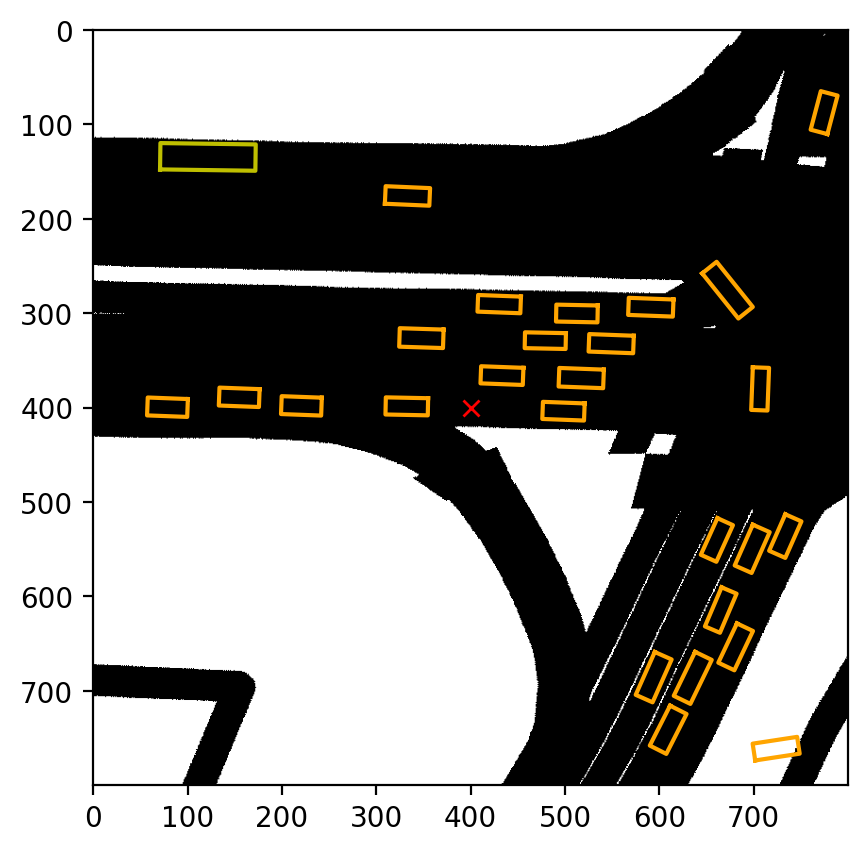

In [72]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
# We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$


In [0]:
model